In [ ]:
!pip install --user kaggle
!pip install opendatasets

In [236]:
import tensorflow as tf
import numpy as np
import os
import random

from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from skimage.io import imread, imshow
from skimage.transform import resize


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

### Load dataset and preprocessing for Unet

In [ ]:
!mkdir -p ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c data-science-bowl-2018
#Download the dataset from kaggle
!kaggle competitions download -c data-science-bowl-2018


In [38]:
!ls './data-science-bowl-2018'

stage1_sample_submission.csv.zip       stage1_train_labels.csv
stage1_solution.csv.zip                stage2_sample_submission_final.csv.zip
stage1_test                            stage2_test_final.zip
stage1_train


In [39]:
import pathlib
from glob import glob

In [64]:
# Image dimension
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Define the paths
training_path = "stage1_train/"
test_path = "stage1_test/"

# get the  training and test folder path
source_path_train = os.path.join(source_path, training_path)
source_path_test = os.path.join(source_path, test_path)

# get the folder ids
train_folder_ids = next(os.walk(source_path_train))[1]
test_folder_ids= next(os.walk(source_path_test))[1]


source_path_train


'./data-science-bowl-2018/stage1_train/'

In [178]:


def get_training_dataset(file_ids=train_folder_ids, path=source_path_train):
    print("Resizing training dataset")
    
    X_train = np.zeros((len(file_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(file_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

    for n, id_ in tqdm(enumerate(train_folder_ids), total=len(file_ids)):
        fname = path + id_
        img = imread(fname + "/images/" + id_ + ".png")[:,:,:IMG_CHANNELS]
        img = resize(img,(IMG_HEIGHT, IMG_WIDTH), mode="constant", preserve_range=True)
        X_train[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
        for mask_f in next(os.walk(fname + "/masks"))[2]:
            mask_ = imread(fname + "/masks/" + mask_f)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode="constant",
                                         preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)

        Y_train[n] = mask
    
    print("Done!")
    return X_train, Y_train
  
                              

Resizing training dataset
Resizing test images


In [179]:
X_train, Y_train = get_training_dataset()

print(f"The training data is of shape {X_train.shape}")
print(f"The training label is of shape {Y_train.shape}")
print(f"Total number training data(directory) is {len(train_folder_ids)}")

100%|█████████████████████████████████████████████████████| 670/670 [05:58<00:00,  1.87it/s]

The training data is of shape (670, 128, 128, 3)
The training label is of shape (670, 128, 128, 1)
Total number training data(directory) is 670
Total number test data(directory) is 65


In [187]:
# Resizing test images

def get_resize_test_dataset():
    print("Resizing test images")
    
    X_test  = np.zeros((len(test_folder_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    test_sizes = []

    for n, id_ in tqdm(enumerate(test_folder_ids), total=len(test_folder_ids)):
            fname = source_path_test + id_
            img = imread(fname + "/images/" + id_ + ".png")[:,:,:IMG_CHANNELS]
            test_sizes.append([img.shape[0], img.shape[1]])
            img = resize(img,(IMG_HEIGHT, IMG_WIDTH), mode="constant", preserve_range=True)
            X_test[n] = img
    print("Done!")     
    return X_test


In [188]:
X_test = get_resize_test_dataset()

Resizing test images


100%|███████████████████████████████████████████████████████| 65/65 [00:01<00:00, 34.67it/s]

Done!


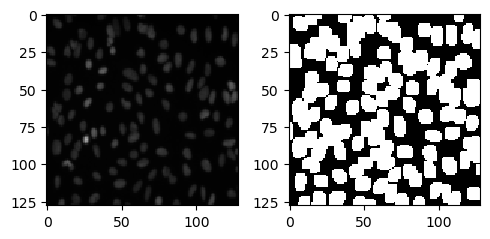

In [223]:


image_x = random.randint(0, len(train_folder_ids))
fig = plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
imshow(X_train[image_x])
plt.subplot(1,2,2)
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [226]:
# Build the model
inputs = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS])

# # Normalize the inputs
# def normalizer(inputs):
#     inputs = tf.cast(inputs, tf.float32) / 255.0
#     return inputs

# Normalize alternative methods
norm_inputs = tf.keras.layers.Lambda(lambda x: x/ 255.0)(inputs)
norm_inputs

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'lambda_3')>

### Define the Unet

In [228]:
# contraction path
from keras import models
from keras import layers

conv1 = tf.keras.layers.Conv2D(16, (3,3),activation="relu", kernel_initializer="he_normal", padding="same")(norm_inputs)
conv1 = tf.keras.layers.Dropout(0.1)(conv1)
conv1 = tf.keras.layers.Conv2D(16, (3,3),activation="relu", kernel_initializer="he_normal", padding="same")(conv1)
pool1 = tf.keras.layers.MaxPool2D((2,2))(conv1)

conv2 = tf.keras.layers.Conv2D(32, (3,3),activation="relu", kernel_initializer="he_normal", padding="same")(pool1)
conv2 = tf.keras.layers.Dropout(0.1)(conv2)
conv2 = tf.keras.layers.Conv2D(32, (3,3),activation="relu", kernel_initializer="he_normal", padding="same")(conv2)
pool2 = tf.keras.layers.MaxPool2D((2,2))(conv2)

conv3 = tf.keras.layers.Conv2D(64, (3,3),activation="relu", kernel_initializer="he_normal", padding="same")(pool2)
conv3 = tf.keras.layers.Dropout(0.1)(conv3)
conv3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(conv3)
pool3 = tf.keras.layers.MaxPool2D((2,2))(conv3)

conv4 = tf.keras.layers.Conv2D(128, (3,3),activation="relu", kernel_initializer="he_normal", padding="same")(pool3)
conv4 = tf.keras.layers.Dropout(0.3)(conv4)
conv4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(conv4)
pool4 = tf.keras.layers.MaxPool2D((2,2))(conv4)

conv5 = tf.keras.layers.Conv2D(256, (3,3),activation="relu", kernel_initializer="he_normal", padding="same")(pool4)
conv5 = tf.keras.layers.Dropout(0.3)(conv5)
conv5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(conv5)

# Expansive path
up6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(conv5)
up6 = tf.keras.layers.concatenate([up6, conv4])
conv6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(up6)
conv6 = tf.keras.layers.Dropout(0.2)(conv6)
conv6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(conv6)

up7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(conv6)
up7 = tf.keras.layers.concatenate([up7, conv3])
conv7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(up7)
conv7 = tf.keras.layers.Dropout(0.1)(conv7)
conv7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(conv7)

up8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(conv7)
up8 = tf.keras.layers.concatenate([up8, conv2])
conv8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(up8)
conv8 = tf.keras.layers.Dropout(0.1)(conv8)
conv8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(conv8)

up9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(conv8)
up9 = tf.keras.layers.concatenate([up9, conv1], axis=3)
conv9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(up9)
conv9 = tf.keras.layers.Dropout(0.1)(conv9)
conv9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(conv9)



outputs = tf.keras.layers.Conv2D(1, (1,1), activation="sigmoid")(conv9)




## Train the model

In [230]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer="adam",
             loss="binary_crossentropy", metrics=["accuracy"])

In [232]:
# define important callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint("model_for_nuclei.h5", verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=1),
    tf.keras.callbacks.TensorBoard(log_dir="logs")
]
        
#Fit model
model.fit(X_train, Y_train, batch_size=16, epochs=25, validation_split=0.1, callbacks=callbacks)

Epoch 1/25
38/38 [==============================] - 81s 2s/step - loss: 0.6459 - accuracy: 0.7273 - val_loss: 0.4735 - val_accuracy: 0.7683
Epoch 2/25
38/38 [==============================] - 64s 2s/step - loss: 0.3952 - accuracy: 0.7766 - val_loss: 0.2821 - val_accuracy: 0.8472
Epoch 3/25
38/38 [==============================] - 80s 2s/step - loss: 0.2598 - accuracy: 0.8837 - val_loss: 0.2092 - val_accuracy: 0.9003
Epoch 4/25
38/38 [==============================] - 78s 2s/step - loss: 0.1983 - accuracy: 0.9141 - val_loss: 0.1695 - val_accuracy: 0.9329
Epoch 5/25
38/38 [==============================] - 71s 2s/step - loss: 0.1616 - accuracy: 0.9367 - val_loss: 0.1442 - val_accuracy: 0.9418
Epoch 6/25
38/38 [==============================] - 76s 2s/step - loss: 0.1508 - accuracy: 0.9431 - val_loss: 0.1475 - val_accuracy: 0.9450
Epoch 7/25
38/38 [==============================] - 72s 2s/step - loss: 0.1417 - accuracy: 0.9469 - val_loss: 0.1252 - val_accuracy: 0.9523
Epoch 8/25
38/38 [==

3/3 [==============================] - 3s 855ms/step


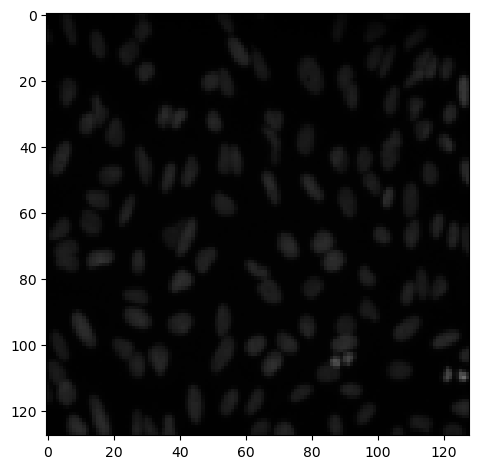

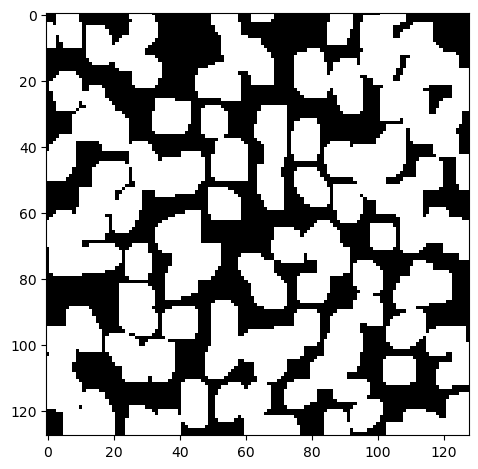

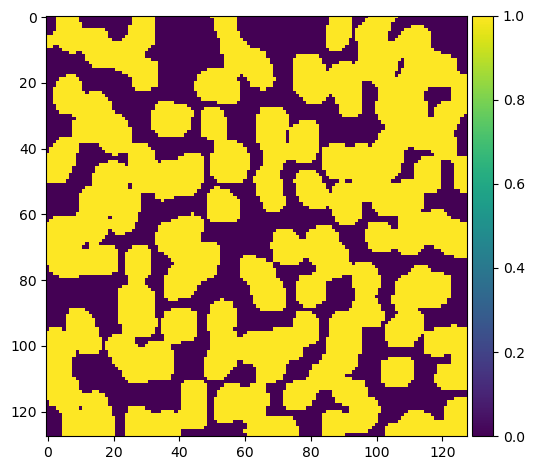

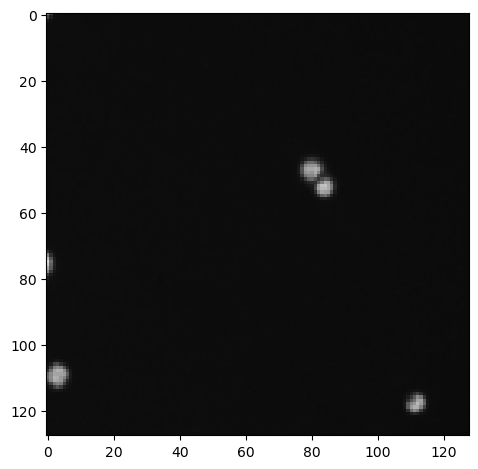

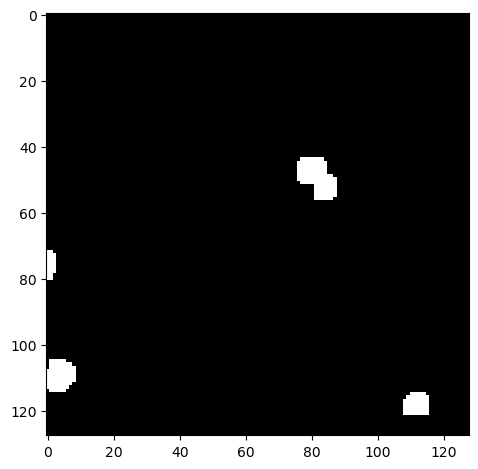

<function matplotlib.pyplot.show(close=None, block=None)>

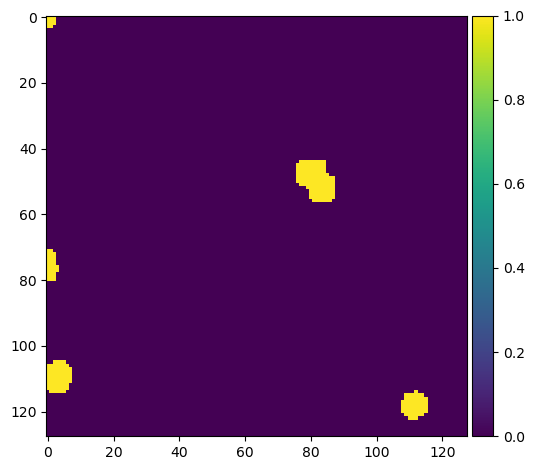

In [250]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()


ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show